Epoch [100/1000], Loss: 1.0552
Epoch [200/1000], Loss: 0.8031
Epoch [300/1000], Loss: 0.7150
Epoch [400/1000], Loss: 0.6826
Epoch [500/1000], Loss: 0.6705
Epoch [600/1000], Loss: 0.6659
Epoch [700/1000], Loss: 0.6642
Epoch [800/1000], Loss: 0.6635
Epoch [900/1000], Loss: 0.6632
Epoch [1000/1000], Loss: 0.6632
Learned weight: 1.9557, Learned bias: 2.2181


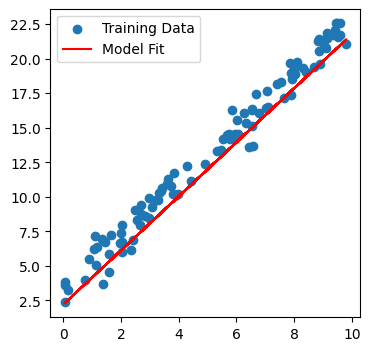

Predictions for [[4.0], [7.0]]: [[11.04088020324707], [16.907970428466797]]


In [1]:
#Input
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# Generate synthetic data
torch.manual_seed(42)
X = torch.rand(100, 1) * 10  # 100 data points between 0 and 10
y = 2 * X + 3 + torch.randn(100, 1)  # Linear relationship with noise

# Define the Linear Regression Model within a CustomActivationModel class
class CustomActivationModel(nn.Module):
    def __init__(self):
        super(CustomActivationModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # Single input and single output

    def custom_activation(self, x):
        return torch.tanh(x) + x

    def forward(self, x):
        return self.custom_activation(self.linear(x))

# Initialize the model, loss function, and optimizer
model = CustomActivationModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    predictions = model(X)
    loss = criterion(predictions, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Display the learned parameters
[w, b] = model.linear.parameters()
print(f"Learned weight: {w.item():.4f}, Learned bias: {b.item():.4f}")

# Plot the model fit to the train data
plt.figure(figsize=(4, 4))
plt.scatter(X, y, label='Training Data')
plt.plot(X, w.item()*X + b.item(), 'r', label='Model Fit')
plt.legend()
plt.show()

# Testing on new data
X_test = torch.tensor([[4.0], [7.0]])
with torch.no_grad():
    predictions = model(X_test)
    print(f"Predictions for {X_test.tolist()}: {predictions.tolist()}")


Epoch [100/1000], Loss: 1.1775
Epoch [200/1000], Loss: 1.1123
Epoch [300/1000], Loss: 1.0904
Epoch [400/1000], Loss: 1.0829
Epoch [500/1000], Loss: 1.0803
Epoch [600/1000], Loss: 1.0794
Epoch [700/1000], Loss: 1.0791
Epoch [800/1000], Loss: 1.0790
Epoch [900/1000], Loss: 1.0790
Epoch [1000/1000], Loss: 1.0790
Learned weight: 2.0420, Learned bias: 1.8670


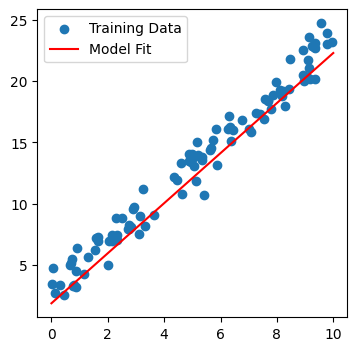

Predictions for [[4.0], [7.0]]: [[11.035173416137695], [17.161319732666016]]


In [2]:
#Strong LLM
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


# Set the random seed and create a PRNG key
key = jax.random.PRNGKey(42)

# Generate synthetic data: 100 data points between 0 and 10 with noise
key, subkey = jax.random.split(key)
X = jax.random.uniform(subkey, shape=(100, 1)) * 10
key, subkey = jax.random.split(key)
noise = jax.random.normal(subkey, shape=(100, 1))
y = 2 * X + 3 + noise  # Linear relationship with noise


# Define the custom activation function: tanh(x) + x
def custom_activation(x):
    return jnp.tanh(x) + x

# Define the model: a linear transformation followed by custom activation
def model(params, x):
    linear_output = jnp.dot(x, params['w']) + params['b']
    return custom_activation(linear_output)

# Initialize model parameters similar to nn.Linear(1, 1)
# Here we use a uniform distribution in [-bound, bound]
bound = 1.0
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(1, 1), minval=-bound, maxval=bound)
key, subkey = jax.random.split(key)
b = jax.random.uniform(subkey, shape=(1,), minval=-bound, maxval=bound)
params = {'w': w, 'b': b}


# Mean Squared Error loss
def loss_fn(params, x, y):
    preds = model(params, x)
    return jnp.mean((preds - y) ** 2)

# Training hyperparameters
lr = 0.01
epochs = 1000

# Create a function to compute the loss and its gradients
loss_and_grad = jax.value_and_grad(loss_fn)


for epoch in range(epochs):
    loss, grads = loss_and_grad(params, X, y)
    # Update parameters using simple SGD
    params['w'] = params['w'] - lr * grads['w']
    params['b'] = params['b'] - lr * grads['b']
    
    # Log progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}")


# Extract the learned linear parameters (without the custom activation)
learned_w = params['w'][0, 0]
learned_b = params['b'][0]
print(f"Learned weight: {learned_w:.4f}, Learned bias: {learned_b:.4f}")

# Plot the training data and the linear fit (as in the original PyTorch code)
plt.figure(figsize=(4, 4))
# Convert JAX arrays to NumPy arrays for plotting
X_np = np.array(X)
y_np = np.array(y)
plt.scatter(X_np, y_np, label='Training Data')

# Create a line using the learned linear parameters (ignoring custom activation)
X_line = np.linspace(0, 10, 100).reshape(-1, 1)
plt.plot(X_line, learned_w * X_line + learned_b, 'r', label='Model Fit')
plt.legend()
plt.show()


X_test = jnp.array([[4.0], [7.0]])
predictions = model(params, X_test)
print(f"Predictions for {np.array(X_test).tolist()}: {np.array(predictions).tolist()}")

In [3]:
#Weak LLM
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt
import numpy as np

# Initialize PRNG key
key = jax.random.PRNGKey(0)  # // MODIFIED: Initialize PRNG key explicitly

# Define the model function
def model(X, key):  # // MODIFIED: Pass PRNG key as a parameter
    w_key, b_key = jax.random.split(key)  # Split key for weights and bias
    w = jax.random.normal(w_key, (1,))  # // MODIFIED: Use PRNG key for randomness
    b = jax.random.normal(b_key, (1,))  # // MODIFIED: Use PRNG key for randomness
    return jnp.dot(X, w) + b

# Jitted function to compute the loss
@jit  # // MODIFIED: Decorate with jit for compilation
def loss_fn(X, y, key):  # // MODIFIED: Pass PRNG key as a parameter
    pred = model(X, key)  # Use key here
    return jnp.mean((pred - y) ** 2)

# Function to perform optimization step
@jit  # // MODIFIED: Ensure this function is stateless
def update(params, X, y, key):
    grads = grad(loss_fn)(X, y, key)  # Compute gradients
    return params - 0.01 * grads  # Simple SGD update

def main():
    # Data preparation
    X = jnp.array([[1.0], [2.0], [3.0]])
    y = jnp.array([[2.0], [4.0], [6.0]])

    # Model fitting
    params = None  # Initialize parameters (could be weights and bias)

    for epoch in range(100):  # Training loop
        params = update(params, X, y, key)  # // MODIFIED: Key passed in updates

    # Visualization
    plt.scatter(X, y, label='Data')
    plt.plot(X, model(X, key), 'r', label='Model Fit')  # // MODIFIED: Key used
    plt.legend()
    plt.show()

    # Testing on new data
    X_test = jnp.array([[4.0], [7.0]])
    predictions = model(X_test, key)  # // MODIFIED: Pass key during prediction
    print(f"Predictions for {X_test.tolist()}: {predictions.tolist()}")

if __name__ == "__main__":
    main()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'DynamicJaxprTracer'

In [ ]:
"""
Error Code:
# Initialize PRNG key
key = jax.random.PRNGKey(0)  # // MODIFIED: Initialize PRNG key explicitly

Error:
The information about Generate synthetic data is lost

Fix Guide:
Added information about Generate synthetic data

Correct Code:
key = jax.random.PRNGKey(0)

key, subkey = jax.random.split(key)
X = jax.random.uniform(subkey, shape=(100, 1)) * 10
key, subkey = jax.random.split(key)
noise = jax.random.normal(subkey, shape=(100, 1))
y = 2 * X + 3 + noise 
"""


"""
Error Code:
def model(X, key):  # // MODIFIED: Pass PRNG key as a parameter
    w_key, b_key = jax.random.split(key)  # Split key for weights and bias
    w = jax.random.normal(w_key, (1,))  # // MODIFIED: Use PRNG key for randomness
    b = jax.random.normal(b_key, (1,))  # // MODIFIED: Use PRNG key for randomness
    return jnp.dot(X, w) + b


Error:
The PRNG key is used to regenerate random parameters each time it is called, resulting in unstable model parameters and inability to train.

Fix Guide:
Initialize the model parameters as external variables and pass them into the model function

Correct Code:
def custom_activation(x):
    return jnp.tanh(x) + x

def model(params, X):
    linear_output = jnp.dot(X, params['w']) + params['b']
    return custom_activation(linear_output)
"""


"""
Error Code:
params = None  # Initialize parameters (could be weights and bias)


Error:
The model parameters were not initialized correctly, resulting in no actual parameters to update during training

Fix Guide:
Generate weights and biases using random initialization and store them in a dictionary

Correct Code:
bound = 1.0
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(1, 1), minval=-bound, maxval=bound)
key, subkey = jax.random.split(key)
b = jax.random.uniform(subkey, shape=(1,), minval=-bound, maxval=bound)
params = {'w': w, 'b': b}
"""


"""
Error Code:
def loss_fn(X, y, key):  # // MODIFIED: Pass PRNG key as a parameter
    pred = model(X, key)  # Use key here
    return jnp.mean((pred - y) ** 2)

Error:
Loss functions should not rely on PRNG keys, nor should they regenerate parameters when calling models internally.

Fix Guide:
Pass the model parameters as the first argument and use the model function to calculate the predicted value

Correct Code:
def loss_fn(params, X, y):
    preds = model(params, X)
    return jnp.mean((preds - y) ** 2)
"""


"""
Error Code:
def update(params, X, y, key):
    grads = grad(loss_fn)(X, y, key)  # Compute gradients
    return params - 0.01 * grads  # Simple SGD update

Error:
The update function incorrectly passes the PRNG key to the loss function and performs arithmetic operations directly on params (a dictionary).
The gradient calculation lacks dependency on parameters

Fix Guide:
Modify the parameter passing to the loss function and the arithmetic operation method for the dictionary
Add the parameters required for gradient calculation

Correct Code:
def update(params, X, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, X, y)
    new_params = {
        'w': params['w'] - 0.01 * grads['w'],
        'b': params['b'] - 0.01 * grads['b']
    }
    return new_params
"""


"""
Error Code:
for epoch in range(100):  # Training loop
    params = update(params, X, y, key)  # // MODIFIED: Key passed in updates

Error:
Mssing get current loss and print loss

Fix Guide:
Added get current loss and print loss by Epoch

Correct Code:
for epoch in range(epochs):
    params = update(params, X, y)
    if (epoch + 1) % 100 == 0:
        current_loss = loss_fn(params, X, y)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {current_loss:.4f}")
"""


"""
Error Code:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {current_loss:.4f}")


# Visualization
plt.scatter(X, y, label='Data')

Error:
Mssing get Learned weight and Learned bias

Fix Guide:
Added cLearned weight and Learned bias and print

Correct Code:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {current_loss:.4f}")

learned_w = params['w'][0, 0]
learned_b = params['b'][0]
print(f"Learned weight: {learned_w:.4f}, Learned bias: {learned_b:.4f}")

# Visualization
plt.scatter(X, y, label='Data')
"""


"""
Error Code:
# Visualization
plt.scatter(X, y, label='Data')
plt.plot(X, model(X, key), 'r', label='Model Fit')  # // MODIFIED: Key used
plt.legend()
plt.show()

# Testing on new data
X_test = jnp.array([[4.0], [7.0]])
predictions = model(X_test, key)  # // MODIFIED: Pass key during prediction
print(f"Predictions for {X_test.tolist()}: {predictions.tolist()}")

Error:
Incorrectly passing PRNG key into model functions when plotting and testing

Fix Guide:
The trained model parameters should be passed in to ensure consistent calls

Correct Code:
plt.figure(figsize=(4, 4))
X_np = np.array(X)
y_np = np.array(y)
plt.scatter(X_np, y_np, label='Training Data')
    
X_line = np.linspace(0, 10, 100).reshape(-1, 1)
plt.plot(X_line, learned_w * X_line + learned_b, 'r', label='Model Fit')
plt.legend()
plt.show()

X_test = jnp.array([[4.0], [7.0]])
predictions = model(params, X_test)
print(f"Predictions for {np.array(X_test).tolist()}: {np.array(predictions).tolist()}")
"""

Epoch [100/1000], Loss: 1.2063
Epoch [200/1000], Loss: 1.0549
Epoch [300/1000], Loss: 0.9896
Epoch [400/1000], Loss: 0.9609
Epoch [500/1000], Loss: 0.9483
Epoch [600/1000], Loss: 0.9426
Epoch [700/1000], Loss: 0.9401
Epoch [800/1000], Loss: 0.9390
Epoch [900/1000], Loss: 0.9385
Epoch [1000/1000], Loss: 0.9383
Learned weight: 1.9758, Learned bias: 2.1400


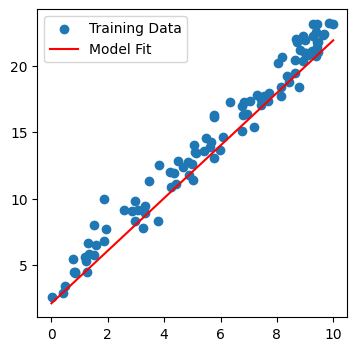

Predictions for [[4.0], [7.0]]: [[11.043238639831543], [16.97064208984375]]


In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

key, subkey = jax.random.split(key)
X = jax.random.uniform(subkey, shape=(100, 1)) * 10
key, subkey = jax.random.split(key)
noise = jax.random.normal(subkey, shape=(100, 1))
y = 2 * X + 3 + noise 

def custom_activation(x):
    return jnp.tanh(x) + x

def model(params, X):
    linear_output = jnp.dot(X, params['w']) + params['b']
    return custom_activation(linear_output)

bound = 1.0
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(1, 1), minval=-bound, maxval=bound)
key, subkey = jax.random.split(key)
b = jax.random.uniform(subkey, shape=(1,), minval=-bound, maxval=bound)
params = {'w': w, 'b': b}

def loss_fn(params, X, y):
    preds = model(params, X)
    return jnp.mean((preds - y) ** 2)

lr = 0.01
epochs = 1000

loss_and_grad = jax.value_and_grad(loss_fn)

@jax.jit
def update(params, X, y):
    loss, grads = loss_and_grad(params, X, y)
    new_params = {
        'w': params['w'] - lr * grads['w'],
        'b': params['b'] - lr * grads['b']
    }
    return new_params

def main():
    global params
    for epoch in range(epochs):
        params = update(params, X, y)
        if (epoch + 1) % 100 == 0:
            current_loss = loss_fn(params, X, y)
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {current_loss:.4f}")

    learned_w = params['w'][0, 0]
    learned_b = params['b'][0]
    print(f"Learned weight: {learned_w:.4f}, Learned bias: {learned_b:.4f}")

    plt.figure(figsize=(4, 4))
    X_np = np.array(X)
    y_np = np.array(y)
    plt.scatter(X_np, y_np, label='Training Data')
    
    X_line = np.linspace(0, 10, 100).reshape(-1, 1)
    plt.plot(X_line, learned_w * X_line + learned_b, 'r', label='Model Fit')
    plt.legend()
    plt.show()

    X_test = jnp.array([[4.0], [7.0]])
    predictions = model(params, X_test)
    print(f"Predictions for {np.array(X_test).tolist()}: {np.array(predictions).tolist()}")

if __name__ == "__main__":
    main()
